# Contexto do Problema

A **Olist** é uma startup brasileira que atua no segmento de e-commerce, sobretudo por meio de marketplace.

De um lado, a olist concentra vendedores que desejam anunciar em marketplaces como Mercado Livre, B2W, Via Varejo e Amazon. Do outro lado, concentra os produtos de todos os vendedores em uma loja única que fica visível ao consumidor final.

# Problema

A diretoria da empresa viu que grande parte dos clientes acabavam justificando que não finalizaram a compra por não possuir dinheiro no momento e não possuir cartão de crédito para parcelar.

A empresa decidiu criar um cartão de crédito próprio para oferecer aos seus clientes, com o objetivo de alavancar as vendas, impedindo que os clientes deixem de comprar por não possuir um cartão.

Em primeiro momento, a estratégia é identificar, em sua base, quem são os clientes que costumam pagar com cartão de crédito de bancos e que não possuem cartão para enviar um email marketing oferencendo 15% de desconto em compras usando o novo cartão da Olist.

**O principal ponto é identificar quem são os clientes que receberão os emails**.

# 0.0 IMPORTS

In [8]:
# manipulação de dados e calculos
import pandas as pd
import numpy as np

# visualização de dados
import seaborn as sns
import matplotlib.pyplot as plt

# processamento
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# validacao
import sklearn.metrics as metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

# modelos
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier

# config warnings
import warnings
warnings.filterwarnings('ignore')

## 0.1 Funções Auxilares

In [9]:
# função para validação
def plot_metric(y_true, yhat, model_name):
    
    matrix = confusion_matrix(y_true, yhat)
    palette = ['#67b79e', '#fda664']

    # show metric
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    sns.heatmap(matrix, annot=True, cmap='Greens')
    plt.title('Confusion Matrix')

    # figure with real data
    plt.subplot(1, 3, 2)
    sns.barplot(x=y_true['payment_type'].value_counts().index, y=y_true['payment_type'].value_counts().values, palette=palette, ec='k')
    plt.title('Forma de Pagamento - (REAL)')
    plt.xlabel('Pagamento - 1 = Crédito | 0 = Outros')
    sns.despine(right=True)

    # figure with prediction
    plt.subplot(1, 3, 3)
    pred = pd.Series(yhat).value_counts()
    sns.barplot(x=pred.index, y=pred.values, palette=palette, ec='k')
    plt.title('Forma de Pagamento - (Predição)')
    plt.xlabel('Pagamento - 1 = Crédito | 0 = Outros')
    sns.despine(right=True)
    plt.suptitle(model_name);
    
    

# Função para calcular metricas
def compute_metrics(yhat, y_validation, model_name):
    
    metric = pd.DataFrame(
        {'Model_name': model_name,
         'Accuracy': accuracy_score(y_validation, yhat),
         'Precision': precision_score(y_validation, yhat),
         'Recall': recall_score(y_validation, yhat)
        }, index=[0])
    
    return metric

## 0.2 Carregamento de Dados

Ao todo, usaremos 8 tabelas/arquivos que foi tirada de um banco de dados. Cada tabela se relaciona através de um Id.

In [10]:
# arquivos/tabelas usadas
tb_customer    = pd.read_csv('data/olist_customers_dataset.csv') 
tb_geolacation = pd.read_csv('data/olist_geolocation_dataset.csv').rename(columns={'geolocation_zip_code_prefix': 'zip_code_prefix'}) 
tb_items       = pd.read_csv('data/olist_order_items_dataset.csv')
tb_payment     = pd.read_csv('data/olist_order_payments_dataset.csv') 
tb_order       = pd.read_csv('data/olist_orders_dataset.csv', ) 
tb_product     = pd.read_csv('data/olist_products_dataset.csv')
tb_seller      = pd.read_csv('data/olist_sellers_dataset.csv').rename(columns={'seller_zip_code_prefix': 'zip_code_prefix'})

Para ajuntar as informações dos relacionamentos das tabelas/arquivos, vamos fazer um merge dos ID´s.

In [11]:
# ajuntando através dos relacionamentos
df1  = pd.merge(tb_payment, tb_order, on='order_id', how='left')
df2  = pd.merge(df1, tb_customer, on='customer_id', how='left')
df3  = pd.merge(df2, tb_items, on='order_id', how='left')
df4  = pd.merge(df3, tb_product, on='product_id', how='left')
df5  = pd.merge(df4, tb_seller, on='seller_id', how='left')
data = pd.merge(df5, tb_geolacation, on='zip_code_prefix', how='left')

Na tabela de pagamentos, há uma variavel (**payment_type**) com as informações históricas sobre a forma de pagamento que o cliente usou. Entre as opções, há se ele pegou com cartão de crédito, boleto, voucher, débito, entre outros.

Para prevermos se o cliente irá pagar com crédito ou não, transformaremos a variavel para binaria. Exemplo: se pagamento == 'cartao de credito' tranforma em 1. Se não, transforma em 0.

In [12]:
# criando variavel target -> if pagamento = credito: 1, else: 0
PAGAMENTO_CREDITO = 1
OUTROS_PAGAMENTOS = 0

# atualizando a colunas com os novos valores
data['payment_type'] = np.where(
    data['payment_type']=='credit_card',
    PAGAMENTO_CREDITO, OUTROS_PAGAMENTOS
)

O conjunto de dados completo possui mais de 16 Milhões de linhas, ao rodar estava dando erro de memoria, sendo impossóvel de executar as céluas de códigos. Portanto, diminuiremos o dataset para 5 Milhões de linhas.

In [13]:
quantidade_linha_nova = 5000000 
data = data.sample(quantidade_linha_nova, random_state=42).copy()

# 1.0 DESCRIÇÃO DE DADOS

## 1.1 Dimensão de Dados

In [14]:
qty_rows    = data.shape[0]  # quantidade de linhas
qty_columns = data.shape[1]  # quantidade de colunas

# mostrando quantidade de linhas e colunas
print('Qty. columns:', qty_columns)
print('Qty. rows:', qty_rows)

Qty. columns: 37
Qty. rows: 5000000


## 1.2 Tipo de Dados

In [15]:
# verificando tipo das variaveis
data.dtypes

order_id                          object
payment_sequential                 int64
payment_type                       int32
payment_installments               int64
payment_value                    float64
customer_id                       object
order_status                      object
order_purchase_timestamp          object
order_approved_at                 object
order_delivered_carrier_date      object
order_delivered_customer_date     object
order_estimated_delivery_date     object
customer_unique_id                object
customer_zip_code_prefix           int64
customer_city                     object
customer_state                    object
order_item_id                    float64
product_id                        object
seller_id                         object
shipping_limit_date               object
price                            float64
freight_value                    float64
product_category_name             object
product_name_lenght              float64
product_descript

## 1.3 Dados Ausentes/Nulos

In [16]:
data.isna().sum()

order_id                              0
payment_sequential                    0
payment_type                          0
payment_installments                  0
payment_value                         0
customer_id                           0
order_status                          0
order_purchase_timestamp              0
order_approved_at                   662
order_delivered_carrier_date      52975
order_delivered_customer_date    108003
order_estimated_delivery_date         0
customer_unique_id                    0
customer_zip_code_prefix              0
customer_city                         0
customer_state                        0
order_item_id                       239
product_id                          239
seller_id                           239
shipping_limit_date                 239
price                               239
freight_value                       239
product_category_name             70044
product_name_lenght               70044
product_description_lenght        70044


## 1.4 Tratamento de Dados Nulos

Como o dataset possui uma grande quantidade de registros (16 milhões), excluir os valores ausentes não fará tanto falto devido a pequena proporção que representa do conjunto de dados.

In [17]:
# excluindo valores ausentes/nulos
data.dropna(inplace=True)

# verificando nova quantidade de valores ausentes/nulos
data.isna().sum()

order_id                         0
payment_sequential               0
payment_type                     0
payment_installments             0
payment_value                    0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
customer_unique_id               0
customer_zip_code_prefix         0
customer_city                    0
customer_state                   0
order_item_id                    0
product_id                       0
seller_id                        0
shipping_limit_date              0
price                            0
freight_value                    0
product_category_name            0
product_name_lenght              0
product_description_lenght       0
product_photos_qty               0
product_weight_g                 0
product_length_cm                0
product_height_cm   

## 1.5 Estatistica Descritiva

In [49]:
data[['payment_sequential', 'payment_value', 'price', 'freight_value',
       'product_height_cm', 'product_width_cm', 'seller_state',
       'product_category_name']].describe()

,payment_sequential,payment_value,price,freight_value,product_height_cm,product_width_cm
count,4.823599e+06,4.823599e+06,4.823599e+06,4.823599e+06,4.823599e+06,4.823599e+06
mean,1.088918e+00,1.696308e+02,1.177577e+02,1.988549e+01,1.655434e+01,2.354624e+01
std,6.801227e-01,2.338691e+02,1.723076e+02,1.497960e+01,1.329552e+01,1.146667e+01
min,1.000000e+00,0.000000e+00,8.500000e-01,0.000000e+00,2.000000e+00,6.000000e+00
25%,1.000000e+00,6.211000e+01,4.000000e+01,1.337000e+01,9.000000e+00,1.500000e+01
50%,1.000000e+00,1.080000e+02,7.480000e+01,1.632000e+01,1.300000e+01,2.000000e+01
75%,1.000000e+00,1.890600e+02,1.299900e+02,2.099000e+01,2.000000e+01,3.000000e+01
max,2.600000e+01,1.366408e+04,6.735000e+03,4.096800e+02,1.050000e+02,1.180000e+02


## 1.6 Variaveis

### 1.6.1 Variavel Target

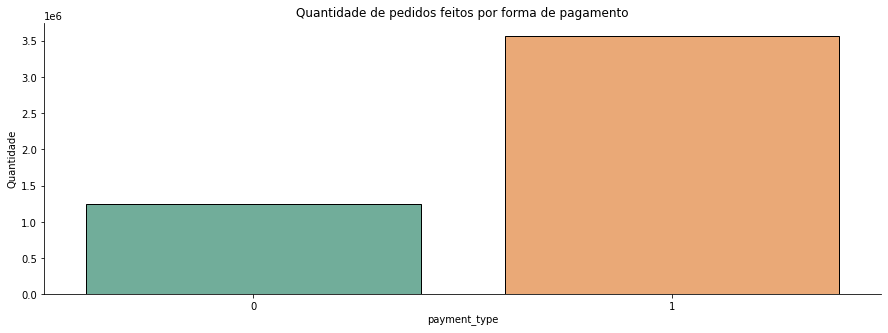

In [56]:
plt.figure(figsize=(15, 5))
sns.countplot(x='payment_type', data=data, palette=['#67b79e', '#fda664'], ec='k')
sns.despine(right=True)
plt.title('Quantidade de pedidos feitos por forma de pagamento')
plt.ylabel('Forma de pagamento')
plt.ylabel('Quantidade');

### 1.6.2 Variaveis Numéricas

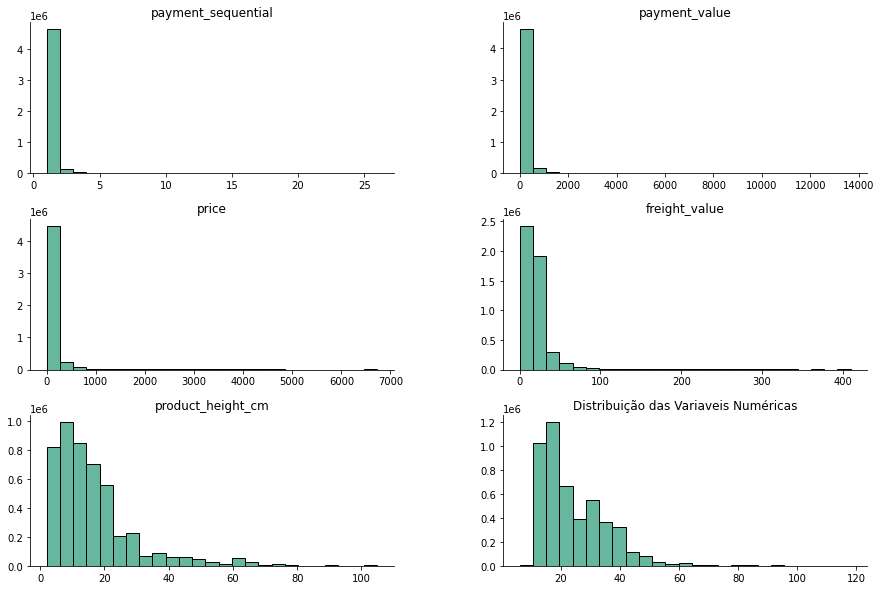

In [68]:
data2 = data[['payment_sequential', 'payment_value', 'price', 'freight_value',
              'product_height_cm', 'product_width_cm', 'seller_state',
              'product_category_name']].copy()

data2.hist(figsize=(15, 10), ec='k', color='#67b79e', bins=25, grid=False)
sns.despine(right=True)
plt.title('Distribuição das Variaveis Numéricas');

# 2.0 DIVISÃO DE DADOS


In [18]:
# separando as variaveis
x = data.drop(columns=['payment_type']) # variaveis independentes
y = data[['payment_type']] # variavel dependente (target)

# dividindo os dados entre treino e teste (20% teste, 80% treinamento)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=43)

# copiando dados para usar no final
x_test2 = x_test.copy()

# 3.0 PREPARAÇÃO DE DADOS

Etapa para realizar o pré-processamento das variaveis para treinar o algotritmo

## 3.1 Dados de Treino

### 3.1.1 Exclusão de Colunas

Excluindo colunas que não são tão relevantes para o aprendizado do modelo e aquelas que dava dica para o modelo acertar.

In [19]:
# colunas para excluir
columns = ["order_id", "customer_id", 'customer_unique_id','order_item_id', 'product_id', 'seller_id',
           "order_status","seller_city","geolocation_city", "geolocation_state", 'customer_city', 'customer_state',
           'order_purchase_timestamp',"order_approved_at", "order_delivered_carrier_date", "order_delivered_customer_date",
           "order_estimated_delivery_date","order_estimated_delivery_date","order_estimated_delivery_date", "shipping_limit_date",
           "customer_zip_code_prefix","zip_code_prefix", "payment_installments", "geolocation_lat", "geolocation_lng",
           'product_length_cm', 'product_weight_g', 'product_photos_qty', 'product_description_lenght',
           'product_name_lenght']

# excluindo colunas com muuitos valores unicos
x_train.drop(columns=columns, inplace=True)

### 3.1.2 Reescalonamento

Etapa para transformar colunas/variaveis numéricas para a mesma escala nos dados de Treino.

In [20]:
# definindo StardarScaler
payment_value     = MinMaxScaler()
price             = MinMaxScaler()
freight_value     = MinMaxScaler()
product_height_cm = MinMaxScaler()
product_width_cm  = MinMaxScaler()

# payment_value
x_train['payment_value'] = payment_value.fit_transform(x_train[['payment_value']].values)

# price
x_train['price'] = price.fit_transform(x_train[['price']].values)

# freight_value
x_train['freight_value'] = freight_value.fit_transform(x_train[['freight_value']].values)

# product_height_cm
x_train['product_height_cm'] = product_height_cm.fit_transform(x_train[['product_height_cm']].values)

# product_width_cm
x_train['product_width_cm'] = product_width_cm.fit_transform(x_train[['product_width_cm']].values)

### 3.1.3 Encoding

Etapa para transformar variaveis caregoricas em 0 e 1 nos dados de Treino.

In [21]:
# Tranformando o Salle_states(SP = 0, RJ = 1)
x_train["seller_state"] = np.where(x_train["seller_state"] == "SP", 0,1)

# criando colunas de 0 e 1 para cada valor de product_category_name
x_train = pd.get_dummies(x_train, prefix='product_category_name', columns=['product_category_name'])

## 3.2 Dados de Teste

### 3.2.1 Exclusão de Colunas

Excluindo colunas que não são tão relevantes para o aprendizado do modelo e aquelas que dava dica para o modelo acertar.

In [22]:
# colunas para excluir
columns = ["order_id", "customer_id", 'customer_unique_id','order_item_id', 'product_id', 'seller_id',
           "order_status","seller_city","geolocation_city", "geolocation_state", 'customer_city', 'customer_state',
           'order_purchase_timestamp',"order_approved_at", "order_delivered_carrier_date", "order_delivered_customer_date",
           "order_estimated_delivery_date","order_estimated_delivery_date","order_estimated_delivery_date", "shipping_limit_date",
           "customer_zip_code_prefix","zip_code_prefix", "payment_installments", "geolocation_lat", "geolocation_lng",
           'product_length_cm', 'product_weight_g', 'product_photos_qty', 'product_description_lenght',
           'product_name_lenght']

# excluindo colunas com muuitos valores unicos
x_test.drop(columns=columns, inplace=True)

### 3.2.2 Reescalonamento

Etapa para transformar colunas/variaveis numéricas para a mesma escala nos dados de Teste.

In [23]:
# definindo StardarScaler
payment_value2     = MinMaxScaler()
price2             = MinMaxScaler()
freight_value2     = MinMaxScaler()
product_height_cm2 = MinMaxScaler()
product_width_cm2  = MinMaxScaler()

# payment_value
x_test['payment_value'] = payment_value2.fit_transform(x_test[['payment_value']].values)

# price
x_test['price'] = price2.fit_transform(x_test[['price']].values)

# freight_value
x_test['freight_value'] = freight_value2.fit_transform(x_test[['freight_value']].values)

# product_height_cm
x_test['product_height_cm'] = product_height_cm2.fit_transform(x_test[['product_height_cm']].values)

# product_width_cm
x_test['product_width_cm'] = product_width_cm2.fit_transform(x_test[['product_width_cm']].values)


### 3.2.3 Encoding

Etapa para transformar variaveis caregoricas em 0 e 1 nos dados de Teste.

In [24]:
# Tranformando o Salle_states(SP = 0, RJ = 1)
x_test["seller_state"] = np.where(x_test["seller_state"] == "SP", 0, 1)

# criando colunas de 0 e 1 para cada valor de product_category_name
x_test = pd.get_dummies(x_test, prefix='product_category_name', columns=['product_category_name'])

# 4.0 MODELAGEM MACHINE LEARNING

Etapa para realizar o treinamento dos algoritmos/modelos para prever a forma de pagamento.

## 4.1 Arvore de Decisão

In [25]:
# definindo arvore com 11 folhas
tree = DecisionTreeClassifier(max_depth=15)

# treinando a arvore com os dados de treino
tree_treinada = tree.fit(x_train, y_train)

# usando a arvore treinada para prever nos dados de teste
tree_predicao = tree_treinada.predict(x_test)

## 4.2 Regressão Logistica

In [26]:
 # definindo a regressão logistica
lr = LogisticRegression()

# treinando a regressão logistica com os dados de treino
lr_treinado = lr.fit(x_train, y_train)

# usando a regressão logistica para prever nos dados de teste
predicao_lr = lr_treinado.predict(x_test)

## 4.3 Random Forest

In [27]:
# definindo a Random Forest
rf = RandomForestClassifier(max_depth=15)

# treinando a Random Forest com os dados de treino
rf_treinado = rf.fit(x_train, y_train)

# usando a Random Forest para prever nos dados de teste
predicao_rf = rf_treinado.predict(x_test)

## 4.4 Naive Bayes

In [28]:
 # definindo o Naive Bayes
bayes = GaussianNB()

# treinando o Naive Bayes com os dados de treino
bayes_treinado = bayes.fit(x_train, y_train)

# usando o Naive Bayes para prever nos dados de teste
predicao_bayes = bayes_treinado.predict(x_test)

## 4.5 XGBoost

In [29]:
 # definindo o XGBoost
xgb = xgb.XGBClassifier(max_depth=9)

# treinando o XGBoost com os dados de treino
xgb_treinado = xgb.fit(x_train, y_train)

# usando o XGBoost para prever nos dados de teste
predicao_xgb = xgb_treinado.predict(x_test)

## 4.6 LGBM

In [30]:
 # definindo o lgbm
lgbm = LGBMClassifier(max_depth=9)

# treinando o lgbm com os dados de treino
lgbm_treinado = lgbm.fit(x_train, y_train)

# usando o lgbm para prever nos dados de teste
predicao_lgbm = lgbm_treinado.predict(x_test)

# 5.0 VALIDAÇÃO

Etapa para validar a performance dos modelos/algoritmos.

## 5.1 Arvore de Decisão

,Model_name,Accuracy,Precision,Recall
0,Arvore de Decisão,0.796719,0.787087,0.994216


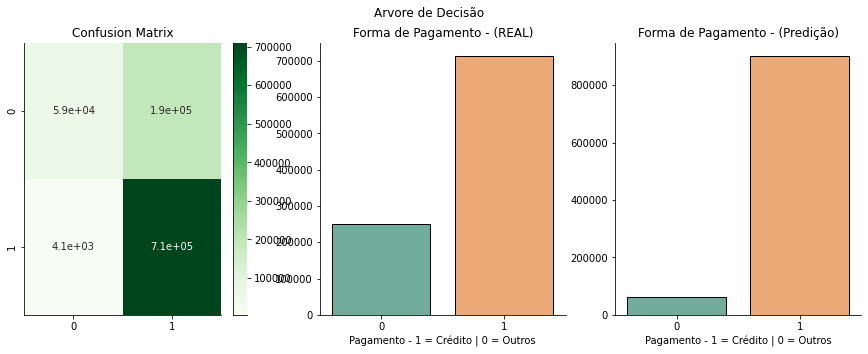

In [31]:
# Arvore de Decisao
metrics_tree = compute_metrics(model_name='Arvore de Decisão', y_validation=y_test, yhat=tree_predicao) # calcula metricas
plot_metric(y_test, tree_predicao, 'Arvore de Decisão') # graficos
metrics_tree # mostra metricas

## 5.2 Regressão Logistica

,Model_name,Accuracy,Precision,Recall
0,Regressão Logistica,0.777575,0.770687,0.995647


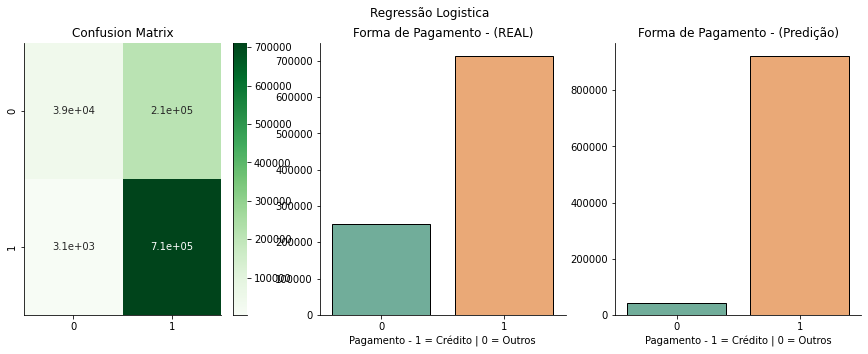

In [32]:
# Regressão Logistica
metrics_lr = compute_metrics(model_name='Regressão Logistica', y_validation=y_test, yhat=predicao_lr) # calcula metricas
plot_metric(y_test, predicao_lr, 'Regressão Logistica') # graficos
metrics_lr # mostra metricas

## 5.3 Random Forest

,Model_name,Accuracy,Precision,Recall
0,Random Forest,0.786,0.776747,0.997484


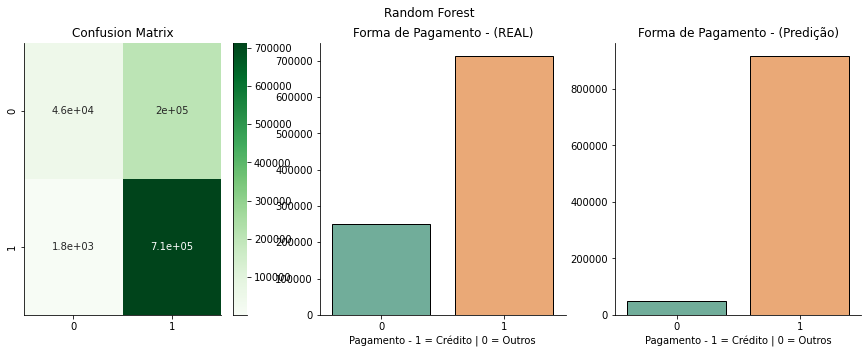

In [33]:
# Random Forest
metrics_rf = compute_metrics(model_name='Random Forest', y_validation=y_test, yhat=predicao_rf) # calcula metricas
plot_metric(y_test, predicao_rf, 'Random Forest') # graficos
metrics_rf # mostra metricas

## 5.4 Naive Bayes

,Model_name,Accuracy,Precision,Recall
0,Naive Bayes,0.755897,0.772999,0.948701


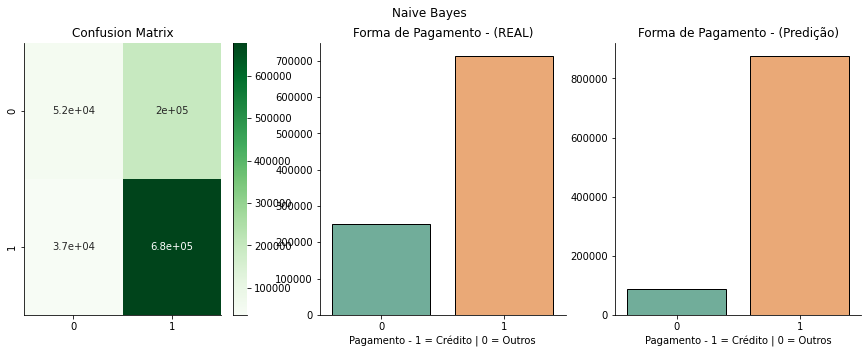

In [34]:
# Naive Bayes
metrics_bayes = compute_metrics(model_name='Naive Bayes', y_validation=y_test, yhat=predicao_bayes) # calcula metricas
plot_metric(y_test, predicao_bayes, 'Naive Bayes') # graficos
metrics_bayes # mostra metricas

## 5.5 XGBoost

,Model_name,Accuracy,Precision,Recall
0,XGBoost,0.846388,0.829261,0.997848


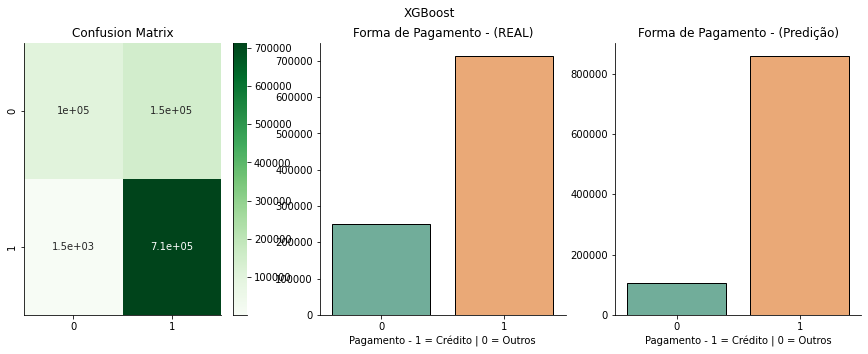

In [35]:
# XGBoost
metrics_xgboost = compute_metrics(model_name='XGBoost', y_validation=y_test, yhat=predicao_xgb) # calcula metricas
plot_metric(y_test, predicao_xgb, 'XGBoost') # graficos
metrics_xgboost # mostra metricas

## 5.6 LGBM

,Model_name,Accuracy,Precision,Recall
0,LGBM,0.785499,0.777135,0.995635


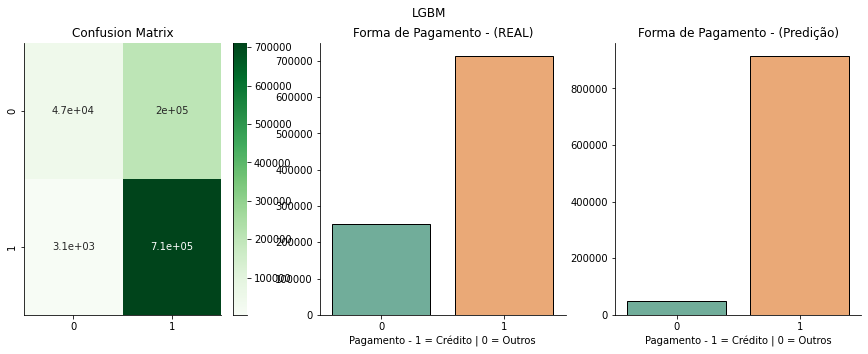

In [36]:
# LGBM
metrics_lgbm = compute_metrics(model_name='LGBM', y_validation=y_test, yhat=predicao_lgbm) # calcula metricas
plot_metric(y_test, predicao_lgbm, 'LGBM') # graficos
metrics_lgbm # mostra metricas

# 6.0 COMITÊ DE CLASSIFICADOR

## 6.1 Ajuntando Predições

Ajuntando as predições dos 3 melhores modeos:

- Arvore de Decisão
- XGBoost
- Random Forest

In [37]:
# predicoes dos 3 melhores
pred_modelos = pd.DataFrame({
    'arvore_decisao':      list(tree_predicao),
    'xgboost':             list(predicao_xgb),
    'random_forest':       list(predicao_rf)
})


pred_modelos.head()

,arvore_decisao,xgboost,random_forest
0,1,1,1
1,1,1,1
2,1,1,1
3,1,1,1
4,1,1,1


## 6.2 Criando Comitê

In [38]:
arvore    = pred_modelos['arvore_decisao']
xgboost   = pred_modelos['xgboost']
floresta  = pred_modelos['random_forest']

contador_classe1 = 0 # contador de credito
contador_classe0 = 0 # contador de não credito

resultado_comite = []
for tree, xgb, rf in zip(arvore, xgboost, floresta):
    
    # verificando classificacao da Arvore de Decisao
    if tree == 0:
        contador_classe0 += 1
    else:
        contador_classe1 += 1
     
    # verificando classificacao da Regressão Logistica
    if xgb == 0:
        contador_classe0 += 1
    else:
        contador_classe1 += 1
    
    # verificando classificacao da Random Forest
    if rf == 0:
        contador_classe0 += 1
    else:
        contador_classe1 += 1
    
    
    # verificando quem ganhou para salvar
    if contador_classe1 > contador_classe0:
        resultado_comite.append(1)
    else:  
        resultado_comite.append(0)
       
    # zerando contador
    contador_classe1 = 0
    contador_classe0 = 0

# criando coluna com as predições do comite de classifcação gerado
pred_modelos['comite'] = resultado_comite

## 6.3 Validação do Comitê

,Model_name,Accuracy,Precision,Recall
0,Comitê de Classificadores,0.797178,0.785323,0.998973


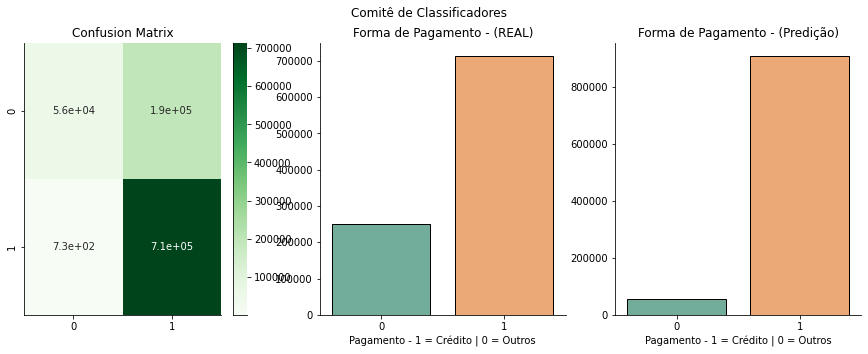

In [39]:
# comite
metrics_comite = compute_metrics(model_name='Comitê de Classificadores', y_validation=y_test, yhat=pred_modelos['comite']) # calcula metricas
plot_metric(y_test, pred_modelos['comite'], 'Comitê de Classificadores') # graficos
metrics_comite # mostra metricas

# 7.0 RESULTADO FINAL

Etapa para gerar a lista das pessoas que pagarão com cartão de crédito.

In [41]:
x_test2['forma_de_pagamento?'] = list(pred_modelos['comite'])

x_test2.sample(20)

,order_id,payment_sequential,payment_installments,payment_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,...,product_height_cm,product_width_cm,zip_code_prefix,seller_city,seller_state,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,forma_de_pagamento?
3567927,1227f9af3b2ddb0b95060aab8e5b3dc7,1,4,47.05,53c9811a9eed9e84d267b8a929840882,delivered,2018-05-10 14:48:29,2018-05-10 15:11:25,2018-05-10 14:00:00,2018-05-18 16:21:53,...,6.0,13.0,13070.0,campinas,SP,-22.884724,-47.076555,campinas,SP,1
5879427,b196564f2fd79a80ab1b31dd8ba4e4fb,1,8,274.56,960ffb45acd270534e88387352742459,delivered,2018-06-06 21:11:57,2018-06-06 21:32:06,2018-06-08 14:13:00,2018-06-18 21:33:33,...,11.0,11.0,13170.0,sumare,SP,-22.823410,-47.271376,sumare,SP,1
15087272,33d4257aa190f034f74c6626a12b6e53,1,10,228.71,c564529ffd5238e134307140271dd186,delivered,2017-09-17 23:00:57,2017-09-17 23:10:18,2017-09-18 19:37:33,2017-10-03 20:45:01,...,22.0,19.0,9230.0,santo andre,SP,-23.615874,-46.526663,santo andre,SP,1
2171984,1f38d4b0b64e26e3aa96c3e8a4afe95e,1,3,163.02,cf25c789086e690ac0787d83feaec0fc,delivered,2018-02-13 14:33:01,2018-02-13 15:08:13,2018-02-15 05:41:44,2018-02-21 16:37:04,...,13.0,14.0,87047.0,maringa,PR,-23.420038,-51.898162,maringa,PR,1
6452744,62e62c8885c148b639ca92db8629c1ac,1,7,96.80,58aee0d0dfbc927800d152c34dc5e530,delivered,2018-02-28 10:14:05,2018-02-28 10:29:47,2018-03-02 18:59:04,2018-03-26 14:52:27,...,20.0,30.0,13232.0,campo limpo paulista,SP,-23.217996,-46.768946,campo limpo paulista,SP,1
4880276,5cc475c7c03290048eb2e742cd64cb5e,1,1,82.69,75e8f990b9e289013b1d092614b52487,delivered,2016-10-04 21:54:52,2016-10-05 03:10:31,2016-12-06 17:24:00,2016-12-12 20:31:54,...,13.0,16.0,14092.0,ribeirao preto,SP,-21.177173,-47.770507,ribeirao preto,SP,1
13291336,07bd0c7e13ac7c3a408dd3bc8f18fc78,1,1,592.18,6888824f6a0a78173ad41847d2dac2f0,delivered,2018-01-30 15:18:07,2018-02-06 17:15:32,2018-02-09 22:05:05,2018-02-14 23:06:46,...,20.0,42.0,35680.0,itauna,MG,-20.088403,-44.598949,itaúna,MG,0
10446337,dc4e9e7d17fec4c4ded41724619a1b10,1,1,45.61,a67749ad2ad8984f58af753299d89756,delivered,2018-02-05 15:22:51,2018-02-05 15:35:58,2018-02-06 17:16:37,2018-02-14 20:08:11,...,15.0,15.0,89460.0,canoinhas,SC,-26.153425,-50.392285,canoinhas,SC,1
2709519,b7624f6b70f7b79ea2b092b6f1be678c,1,4,112.99,a6b19a21cdce23baec63e5e6a0ff8288,delivered,2017-02-03 22:21:47,2017-02-03 22:30:19,2017-02-07 07:38:58,2017-06-14 14:42:22,...,48.0,38.0,37795.0,andradas,MG,-22.064461,-46.563775,andradas,MG,1
8285408,5d8e9c0a711b826b72298f9abeb269cd,1,1,35.86,b21ff624eaefac438d7923cd142bd9c5,delivered,2017-02-06 12:19:55,2017-02-08 03:15:13,2017-02-08 11:41:17,2017-02-13 15:12:46,...,2.0,11.0,15502.0,votuporanga,SP,-20.411639,-49.986775,votuporanga,SP,1
